In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("San Diego_featured_data.csv")
y = df[['All sky irradiance']]

# Scale features and target
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(df)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=True)

# Train base models
cat_model = CatBoostRegressor(learning_rate=0.1,depth=2,l2_leaf_reg=1,iterations=1500)
xgb_model = XGBRegressor(tree_method='approx',subsamples=0.7,n_estimators=300,max_depth=9,learning_rate=0.1,colsample_bytree=1)
rf_model = RandomForestRegressor(n_estimators=60,min_samples_split=2,min_samples_leaf=2,max_samples=0.75,max_features=8,max_depth=8)

cat_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Get base model predictions
cat_pred_train = cat_model.predict(X_train).reshape(-1, 1)
xgb_pred_train = xgb_model.predict(X_train).reshape(-1, 1)
rf_pred_train = rf_model.predict(X_train).reshape(-1, 1)

cat_pred_test = cat_model.predict(X_test).reshape(-1, 1)
xgb_pred_test = xgb_model.predict(X_test).reshape(-1, 1)
rf_pred_test = rf_model.predict(X_test).reshape(-1, 1)

# Stack predictions as input for gating model
train_preds = np.hstack([cat_pred_train, xgb_pred_train, rf_pred_train])
test_preds = np.hstack([cat_pred_test, xgb_pred_test, rf_pred_test])

# Convert to tensors
train_preds_tensor = torch.tensor(train_preds, dtype=torch.float32)
test_preds_tensor = torch.tensor(test_preds, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define the Gating Network
class GatingNetwork(nn.Module):
    def __init__(self, input_size):
        super(GatingNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc3 = nn.Linear(64, 3)  # 3 output weights, one for each model
        self.softmax = nn.Softmax(dim=1)  # Ensures weights sum to 1

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc3(x)
        x = self.softmax(x)



        return x

# Initialize model, optimizer, and loss function
gating_model = GatingNetwork(input_size=train_preds.shape[1])
optimizer = optim.Adam(gating_model.parameters(), lr=0.001)
criterion = nn.L1Loss()

# Train the gating model
epochs = 500
weight_history = []  # To store weight evolution

for epoch in range(epochs):
    gating_model.train()
    optimizer.zero_grad()
    
    # Get dynamic weights
    weights = gating_model(train_preds_tensor)
    
    # Compute the final prediction (weighted sum of base model predictions)
    final_pred = (weights[:, 0].unsqueeze(1) * train_preds_tensor[:, 0].unsqueeze(1)) + \
                 (weights[:, 1].unsqueeze(1) * train_preds_tensor[:, 1].unsqueeze(1)) + \
                 (weights[:, 2].unsqueeze(1) * train_preds_tensor[:, 2].unsqueeze(1))
    
    # Calculate loss
    loss = criterion(final_pred, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Store weight evolution
    avg_weights = weights.mean(dim=0).detach().numpy()
    weight_history.append(avg_weights)

    if epoch % 50 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

# Evaluate on test data
gating_model.eval()
with torch.no_grad():
    test_weights = gating_model(test_preds_tensor)
    
    final_test_pred = (test_weights[:, 0].unsqueeze(1) * test_preds_tensor[:, 0].unsqueeze(1)) + \
                      (test_weights[:, 1].unsqueeze(1) * test_preds_tensor[:, 1].unsqueeze(1)) + \
                      (test_weights[:, 2].unsqueeze(1) * test_preds_tensor[:, 2].unsqueeze(1))

# Convert weight history to numpy array for plotting
weight_history = np.array(weight_history)

# Plot the weight evolution over epochs



0:	learn: 0.9190082	total: 56.4ms	remaining: 1m 24s
1:	learn: 0.8467711	total: 57ms	remaining: 42.7s
2:	learn: 0.7790852	total: 57.2ms	remaining: 28.6s
3:	learn: 0.7202157	total: 57.5ms	remaining: 21.5s
4:	learn: 0.6639101	total: 57.7ms	remaining: 17.3s
5:	learn: 0.6128928	total: 57.9ms	remaining: 14.4s
6:	learn: 0.5697626	total: 58.2ms	remaining: 12.4s
7:	learn: 0.5268285	total: 58.4ms	remaining: 10.9s
8:	learn: 0.4899103	total: 58.6ms	remaining: 9.71s
9:	learn: 0.4575016	total: 58.9ms	remaining: 8.77s
10:	learn: 0.4261937	total: 59.1ms	remaining: 8s
11:	learn: 0.3981598	total: 59.3ms	remaining: 7.35s
12:	learn: 0.3734081	total: 59.5ms	remaining: 6.8s
13:	learn: 0.3464407	total: 59.8ms	remaining: 6.35s
14:	learn: 0.3255366	total: 60ms	remaining: 5.94s
15:	learn: 0.3031639	total: 60.2ms	remaining: 5.59s
16:	learn: 0.2829662	total: 60.4ms	remaining: 5.27s
17:	learn: 0.2651663	total: 60.6ms	remaining: 4.99s
18:	learn: 0.2512346	total: 60.8ms	remaining: 4.74s
19:	learn: 0.2359947	total: 6

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:12:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "subsamples" } are not used.

  warnings.warn(smsg, UserWarning)


Epoch 0/500, Loss: 0.003667756449431181
Epoch 50/500, Loss: 0.0015463633462786674
Epoch 100/500, Loss: 0.0010960176587104797
Epoch 150/500, Loss: 0.0009884468745440245
Epoch 200/500, Loss: 0.0009381259442307055
Epoch 250/500, Loss: 0.0009116089204326272
Epoch 300/500, Loss: 0.0008952411008067429
Epoch 350/500, Loss: 0.000883877684827894
Epoch 400/500, Loss: 0.0008754843729548156
Epoch 450/500, Loss: 0.0008692127885296941


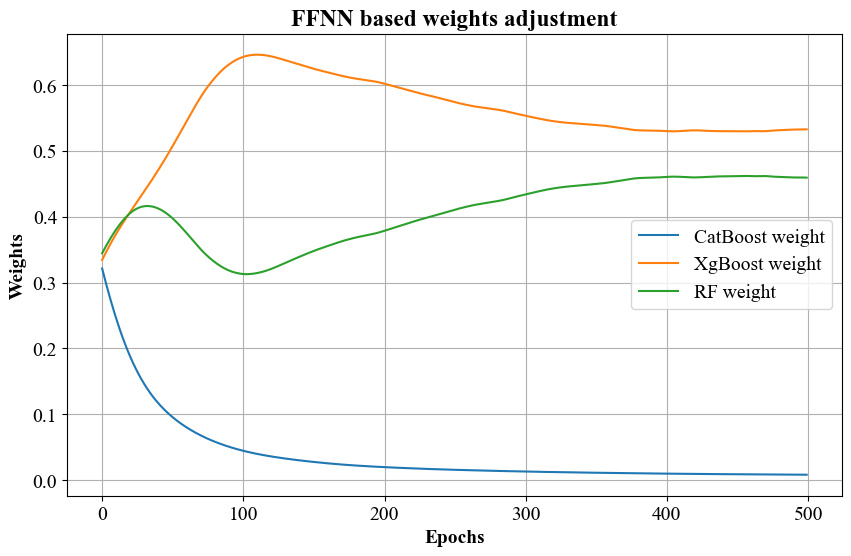

In [8]:
plt.rcParams['font.size'] = '14'
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(10, 6))
plt.plot(weight_history[:, 0], label='CatBoost weight')
plt.plot(weight_history[:, 1], label='XgBoost weight')
plt.plot(weight_history[:, 2], label='RF weight')
plt.xlabel('Epochs', fontweight="bold")
plt.ylabel('Weights', fontweight="bold")
plt.title('FFNN based weights adjustment', fontweight="bold")
plt.legend()
plt.grid()
plt.savefig('San Diego data weight adjustment.pdf') 
plt.savefig('San Diego data weight adjustment.png') 
plt.show()